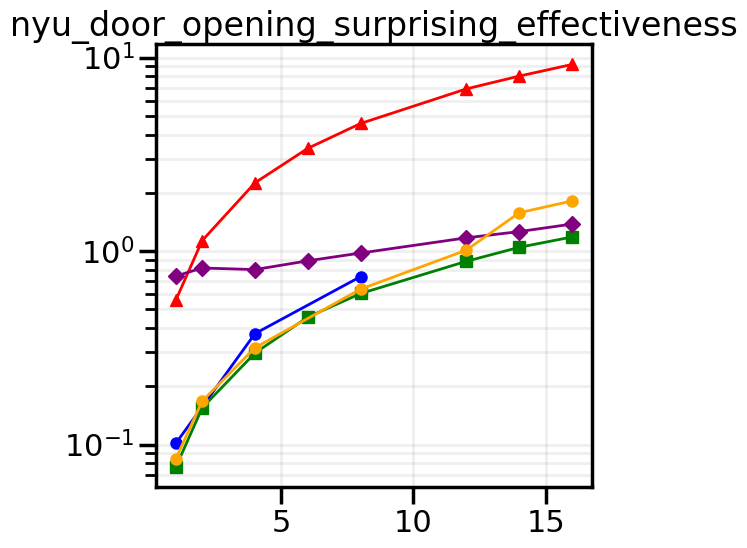

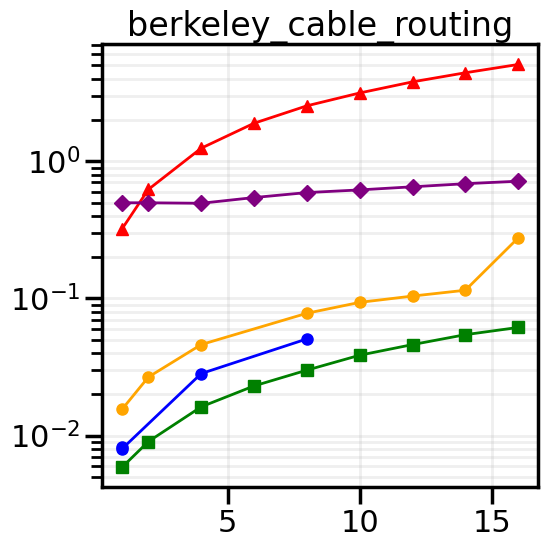

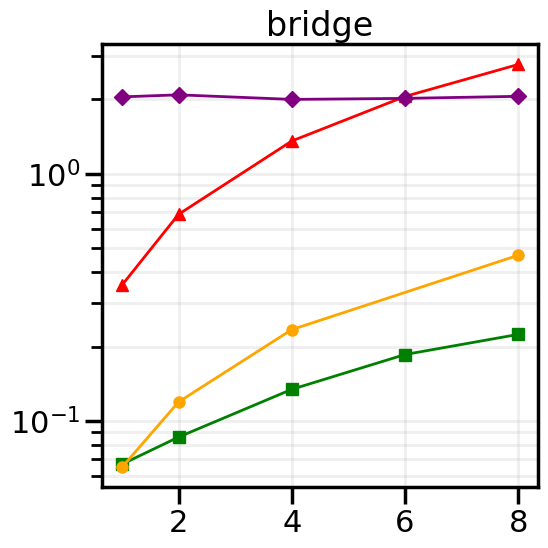

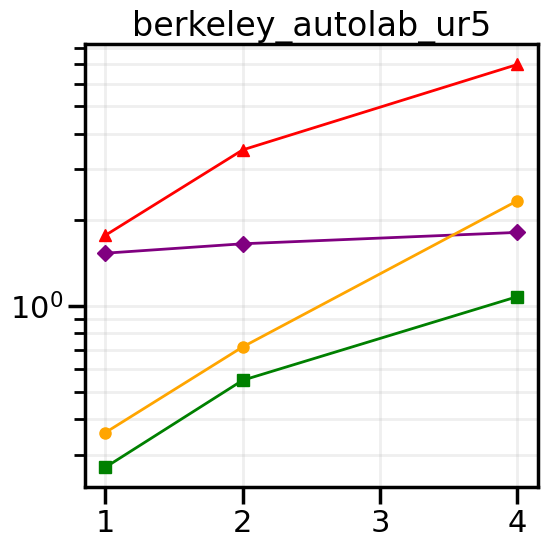

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("poster")
# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Define colors and markers for each format
format_styles = {
    'Fog-VLA-DM': ('blue', 'o'),
    'HDF5': ('green', 's'),
    'LEROBOT': ('red', '^'),
    'RLDS': ('purple', 'D'),
    "Fog-VLA-DM-lossless": ('orange', 'o'),
}

# Update the format name from 'VLA' to 'Fog-VLA-DM' in the DataFrame
df['Format'] = df['Format'].replace('VLA', 'Fog-VLA-DM')
df['Format'] = df['Format'].replace('FFV1', 'Fog-VLA-DM-lossless')

# Update the format_styles dictionary
format_styles['Fog-VLA-DM'] = format_styles.pop('VLA', ('blue', 'o'))

# Get unique datasets and batch sizes
datasets = df['Dataset'].unique()

# Create a figure for each dataset
for dataset in datasets:
    plt.figure(figsize=(6, 6))
    
    dataset_df = df[df['Dataset'] == dataset]
    
    # Create the line plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        plt.plot(data['BatchSize'], data['AverageLoadingTime(s)'], 
                 color=color, marker=marker, label=format, linewidth=2, markersize=8)

    # Customize the plot
    # plt.xlabel('Num of Concurrent Reads')
    # plt.ylabel('Log-Scale Average Loading Time (s)')
    plt.title(f'{dataset}')
    # plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # plt.xscale('log')  # Use log scale for x-axis
    plt.yscale('log')  # Use log scale for y-axis
    plt.tight_layout()  # Adjust layout to make room for the legend
    
    # Add a grid for better readability
    plt.grid(True, which="both", ls="-", alpha=0.2)

    # Show the plot
    plt.tight_layout()
    plt.savefig(f'./{dataset}.pdf')

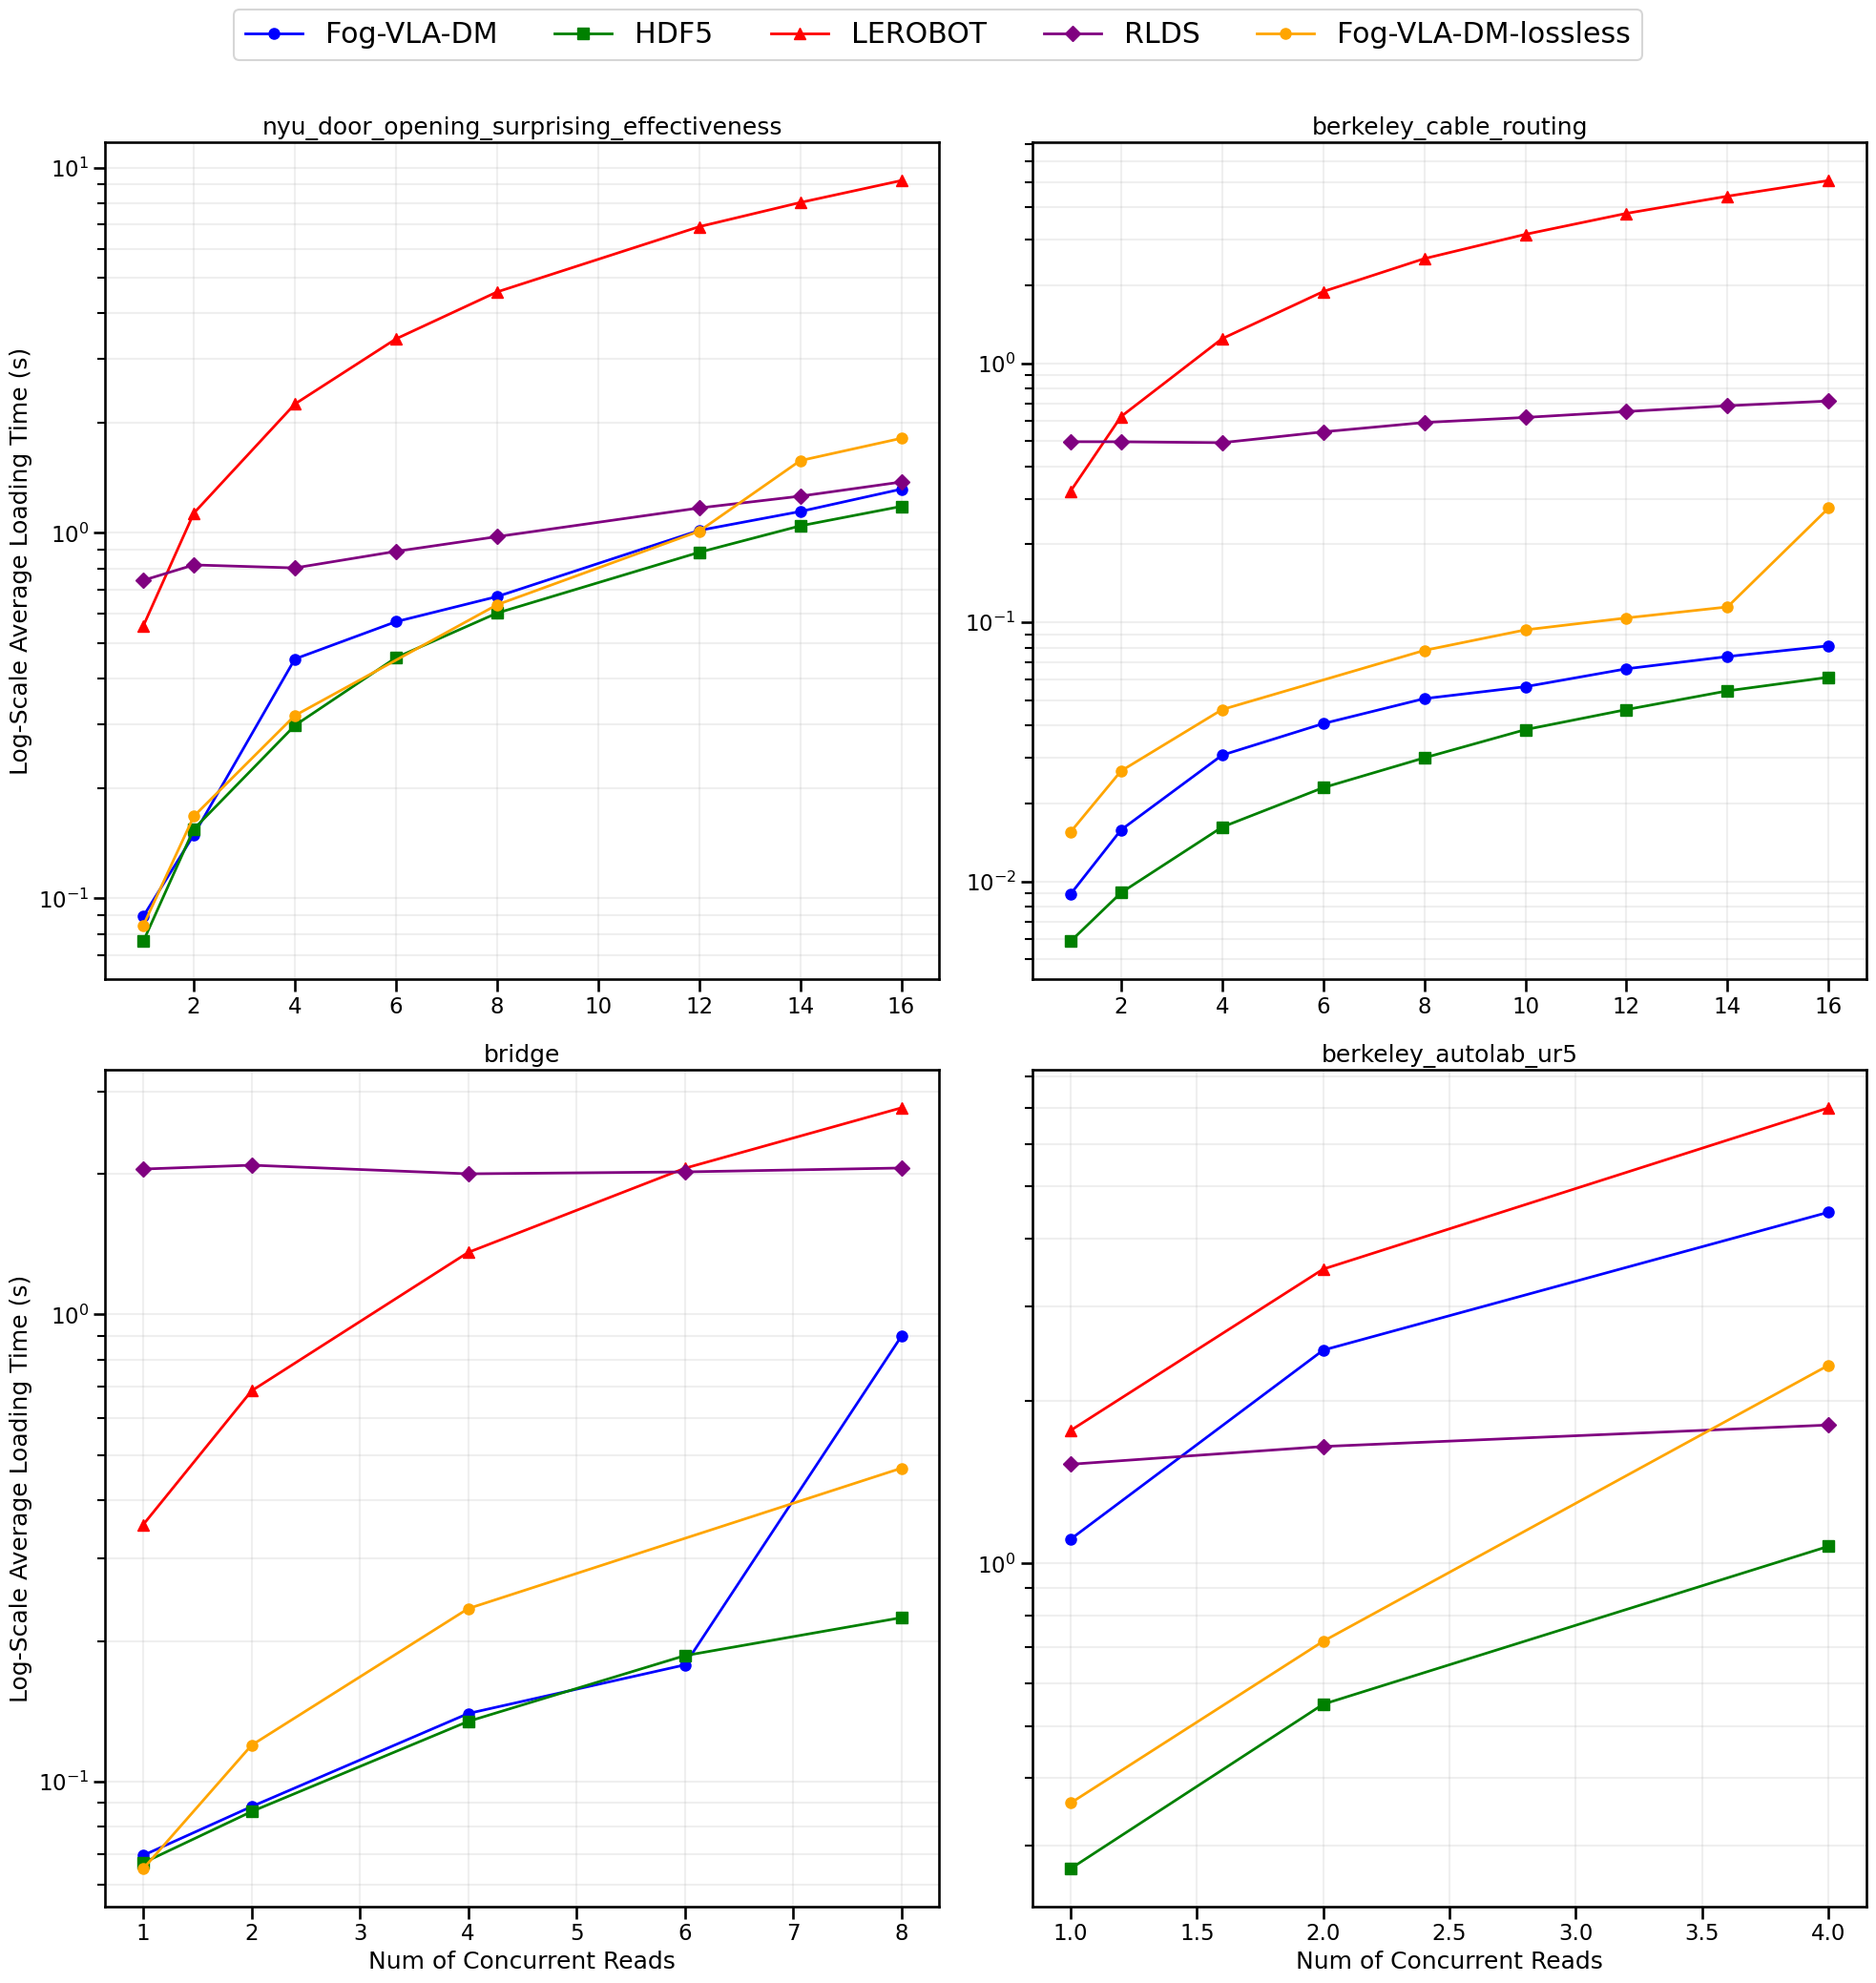

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("talk")

# Read the CSV file
df = pd.read_csv('./format_comparison_results.csv')

# Define colors and markers for each format
format_styles = {
    'Fog-VLA-DM': ('blue', 'o'),
    'HDF5': ('green', 's'),
    'LEROBOT': ('red', '^'),
    'RLDS': ('purple', 'D'),
    "Fog-VLA-DM-lossless": ('orange', 'o'),
}

# Update the format name from 'VLA' to 'Fog-VLA-DM' in the DataFrame
df['Format'] = df['Format'].replace('VLA', 'Fog-VLA-DM')
df['Format'] = df['Format'].replace('FFV1', 'Fog-VLA-DM-lossless')

# Update the format_styles dictionary
format_styles['Fog-VLA-DM'] = format_styles.pop('VLA', ('blue', 'o'))

# Get unique datasets
datasets = df['Dataset'].unique()

# Create a single figure with four subplots
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
axs = axs.flatten()

for idx, dataset in enumerate(datasets):
    ax = axs[idx]
    dataset_df = df[df['Dataset'] == dataset]
    
    # Create the line plot
    for format, (color, marker) in format_styles.items():
        data = dataset_df[dataset_df['Format'] == format]
        ax.plot(data['BatchSize'], data['AverageLoadingTime(s)'], 
                color=color, marker=marker, label=format, linewidth=2, markersize=8)

    # Customize the subplot
    ax.set_title(dataset)
    ax.set_yscale('log')
    ax.grid(True, which="both", ls="-", alpha=0.2)
    
    # Only add x and y labels to the bottom and left subplots
    if idx >= 2:
        ax.set_xlabel('Num of Concurrent Reads')
    if idx % 2 == 0:
        ax.set_ylabel('Log-Scale Average Loading Time (s)')

# Add a single legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=5, fontsize='large')

plt.tight_layout()
plt.savefig('./combined_datasets.pdf', bbox_inches='tight')
plt.show()

In [7]:
# Calculate relative file size for each dataset
results = []

for dataset in df['Dataset'].unique():
    dataset_df = df[df['Dataset'] == dataset]
    
    vla_size = dataset_df[dataset_df['Format'] == 'Fog-VLA-DM']['AverageTrajectorySize(MB)'].mean()
    
    for format in ['Fog-VLA-DM', 'RLDS', 'HDF5', 'LEROBOT', 'Fog-VLA-DM-lossless']:
        format_size = dataset_df[dataset_df['Format'] == format]['AverageTrajectorySize(MB)'].mean()
        relative_size = format_size / vla_size if vla_size != 0 else float('inf')
        
        results.append({
            'Dataset': dataset,
            'Format': format,
            'AverageTrajectorySize(MB)': format_size,
            'RelativeSize': relative_size
        })

results_df = pd.DataFrame(results)

# Pivot the results for easier reading
pivot_df = results_df.pivot_table(values=['AverageTrajectorySize(MB)', 'RelativeSize'], 
                                  index='Dataset', 
                                  columns='Format', 
                                  fill_value='-')

# Display the results
print("File Size (MB):")
print(pivot_df['AverageTrajectorySize(MB)'].to_string(float_format='{:.2f}'.format))
print("\nRelative Size (compared to Fog-VLA-DM):")
print(pivot_df['RelativeSize'].to_string(float_format='{:.2f}'.format))

File Size (MB):
Format                                     Fog-VLA-DM  Fog-VLA-DM-lossless   HDF5  LEROBOT  RLDS
Dataset                                                                                         
berkeley_autolab_ur5                             1.85                25.57 281.55     0.00  0.00
berkeley_cable_routing                           0.68                 1.10   4.87     0.00  0.00
bridge                                           0.31                 4.40  29.91     0.00  0.00
nyu_door_opening_surprising_effectiveness        0.36                 5.78  79.54     0.00  0.00

Relative Size (compared to Fog-VLA-DM):
Format                                     Fog-VLA-DM  Fog-VLA-DM-lossless   HDF5  LEROBOT  RLDS
Dataset                                                                                         
berkeley_autolab_ur5                             1.00                13.80 152.03     0.00  0.00
berkeley_cable_routing                           1.00                 

In [14]:
# Calculate relative performance for each dataset and batch size
results = []

for dataset in df['Dataset'].unique():
    for batch_size in df['BatchSize'].unique():
        dataset_batch_df = df[(df['Dataset'] == dataset) & (df['BatchSize'] == batch_size)]
        
        vla_time = dataset_batch_df[dataset_batch_df['Format'] == 'Fog-VLA-DM']['LoadingTime(s)'].mean()
        
        for format in ['Fog-VLA-DM', 'RLDS', 'HDF5', 'LEROBOT']:
            format_time = dataset_batch_df[dataset_batch_df['Format'] == format]['LoadingTime(s)'].mean()
            relative_performance = format_time / vla_time if vla_time != 0 else float('inf')
            
            results.append({
                'Dataset': dataset,
                'BatchSize': batch_size,
                'Format': format,
                "Latency": format_time,
                'RelativePerformance': relative_performance
            })

results_df = pd.DataFrame(results)

# Pivot the results for easier reading
pivot_df = results_df.pivot_table(values='RelativePerformance', 
                                  index=['Dataset', 'BatchSize'], 
                                  columns='Format', 
                                  fill_value='-')

# Display the results
print(pivot_df.to_string(float_format='{:.2f}'.format))

Format                                               Fog-VLA-DM  HDF5  LEROBOT  RLDS
Dataset                                   BatchSize                                 
berkeley_autolab_ur5                      1                1.00  0.24     1.59  1.38
                                          2                1.00  0.22     1.41  0.66
                                          4                1.00  0.24     1.56  0.40
berkeley_cable_routing                    1                1.00  0.66    35.89 55.75
                                          2                1.00  0.57    39.37 31.47
                                          4                1.00  0.53    40.48 16.07
                                          6                1.00  0.57    46.50 13.36
                                          8                1.00  0.59    49.90 11.63
bridge                                    1                1.00  0.96     5.11 29.46
                                          2                1.00  

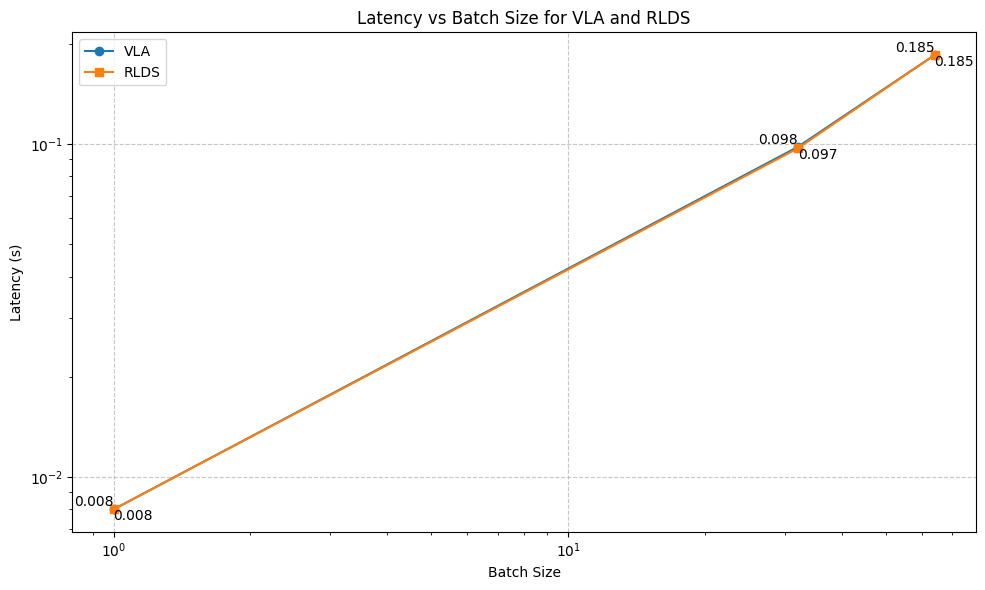

In [1]:
import matplotlib.pyplot as plt

# Data
batch_sizes = [1, 32, 64]
vla_latency = [0.008, 0.098, 0.185]
rlds_latency = [0.008, 0.097, 0.185]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(batch_sizes, vla_latency, marker='o', label='VLA')
plt.plot(batch_sizes, rlds_latency, marker='s', label='RLDS')

# Customize the plot
plt.xlabel('Batch Size')
plt.ylabel('Latency (s)')
plt.title('Latency vs Batch Size for VLA and RLDS')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis to log scale
plt.yscale('log')
plt.xscale('log')

# Add data labels
for x, y in zip(batch_sizes, vla_latency):
    plt.text(x, y, f'{y:.3f}', ha='right', va='bottom')
for x, y in zip(batch_sizes, rlds_latency):
    plt.text(x, y, f'{y:.3f}', ha='left', va='top')

# Show the plot
plt.tight_layout()
plt.show()

In [2]:
df

,Dataset,Format,Trajectory,LoadingTime(s),FileSize(MB),Throughput(traj/s)
0,berkeley_autolab_ur5,RLDS,0,0.045454,237.461549,22.000367
1,berkeley_autolab_ur5,RLDS,1,0.016615,126.826066,60.187754
2,berkeley_autolab_ur5,RLDS,2,0.017593,157.582145,56.839549
3,berkeley_autolab_ur5,RLDS,3,0.017673,157.047621,56.583439
4,berkeley_autolab_ur5,RLDS,4,0.026880,187.195036,37.203005
...,...,...,...,...,...,...
1275,nyu_door_opening_surprising_effectiveness,HDF5,59,0.019514,75.305054,51.246292
1276,nyu_door_opening_surprising_effectiveness,HDF5,60,0.016183,61.434937,61.792713
1277,nyu_door_opening_surprising_effectiveness,HDF5,61,0.028054,108.990044,35.645542
1278,nyu_door_opening_surprising_effectiveness,HDF5,62,0.019443,75.305054,51.432299


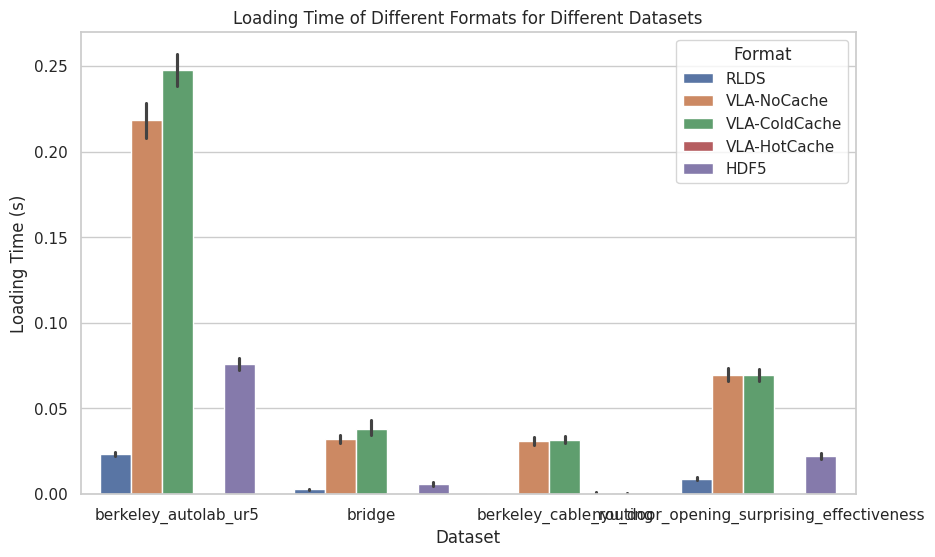

In [3]:
# visualize the data
# dataset to be the x axis, loading time is y axis, and format to be side by side comparison between different bars

sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Dataset", y="LoadingTime(s)", hue="Format", data=df)
plt.title('Loading Time of Different Formats for Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Loading Time (s)')
plt.show()


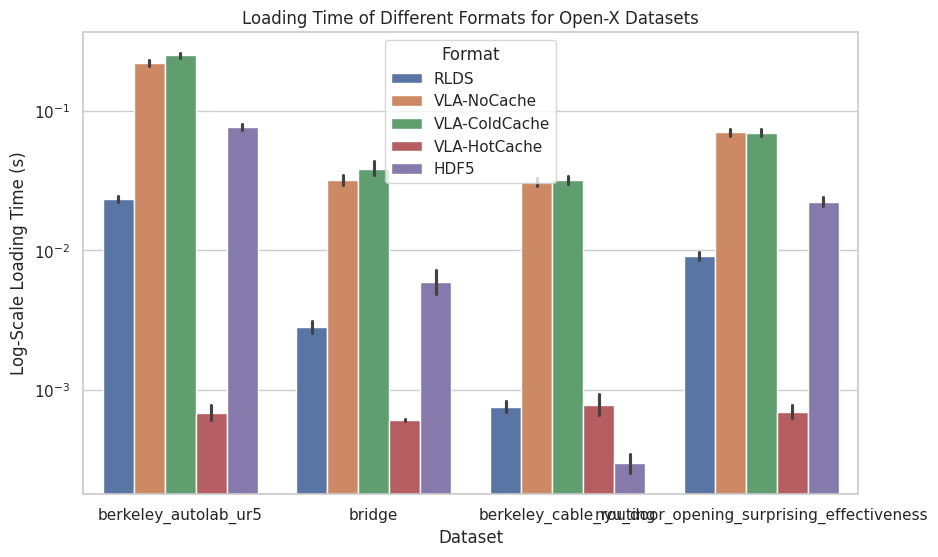

In [4]:
# make previous plot log scale
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Dataset", y="LoadingTime(s)", hue="Format", data=df)
plt.yscale('log')
plt.title('Loading Time of Different Formats for Open-X Datasets')
plt.xlabel('Dataset')
plt.ylabel('Log-Scale Loading Time (s)')
plt.show()


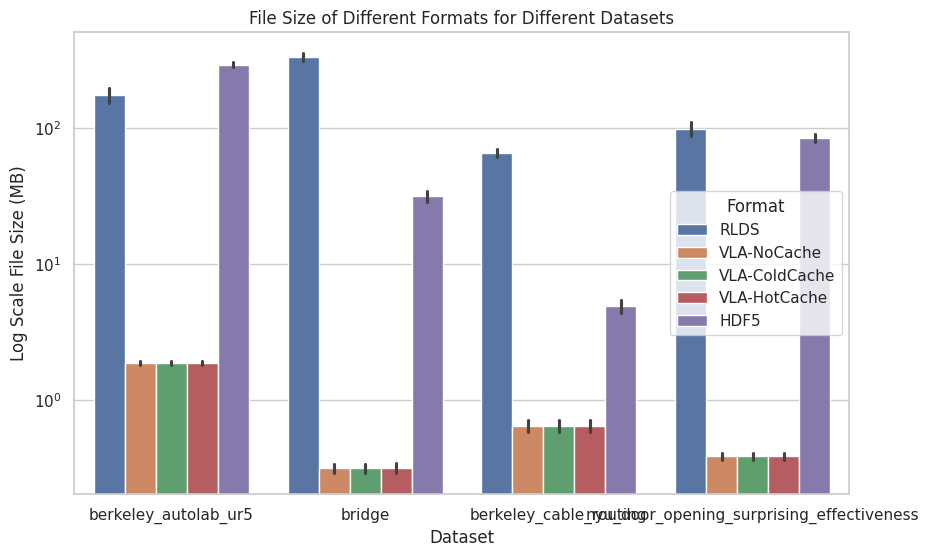

In [8]:
# file sze 
plt.figure(figsize=(10, 6))
ax = sns.barplot(x="Dataset", y="FileSize(MB)", hue="Format", data=df)
plt.yscale('log')
plt.title('File Size of Different Formats for Different Datasets')
plt.xlabel('Dataset')
plt.ylabel('Log Scale File Size (MB)')
plt.show()

In [12]:
# get average loading time and storage for each dataset
df.groupby(['Dataset', 'Format'])['LoadingTime(s)'].mean()


Dataset                                    Format       
berkeley_autolab_ur5                       HDF5             0.075685
                                           RLDS             0.023251
                                           VLA-ColdCache    0.247777
                                           VLA-HotCache     0.000683
                                           VLA-NoCache      0.218245
berkeley_cable_routing                     HDF5             0.000300
                                           RLDS             0.000764
                                           VLA-ColdCache    0.031721
                                           VLA-HotCache     0.000788
                                           VLA-NoCache      0.030931
bridge                                     HDF5             0.005921
                                           RLDS             0.002830
                                           VLA-ColdCache    0.038200
                                           VLA

In [13]:
df.groupby(['Dataset', 'Format'])['FileSize(MB)'].mean()


Dataset                                    Format       
berkeley_autolab_ur5                       HDF5             289.032210
                                           RLDS             174.420469
                                           VLA-ColdCache      1.878984
                                           VLA-HotCache       1.878984
                                           VLA-NoCache        1.878984
berkeley_cable_routing                     HDF5               4.873406
                                           RLDS              65.382843
                                           VLA-ColdCache      0.645619
                                           VLA-HotCache       0.645619
                                           VLA-NoCache        0.645619
bridge                                     HDF5              31.268807
                                           RLDS             330.839012
                                           VLA-ColdCache      0.317214
                    

In [19]:
# compute the speedup of VLA to HDF5 and RLDS per dataset
df.groupby(['Dataset', 'Format'])['FileSize(MB)'].mean() / df.groupby(['Dataset', 'Format'])['LoadingTime(s)'].mean()

Dataset                                    Format       
berkeley_autolab_ur5                       HDF5               3818.869277
                                           RLDS               7501.680810
                                           VLA-ColdCache         7.583370
                                           VLA-HotCache       2752.311319
                                           VLA-NoCache           8.609527
berkeley_cable_routing                     HDF5              16256.118100
                                           RLDS              85611.650199
                                           VLA-ColdCache        20.353238
                                           VLA-HotCache        819.724171
                                           VLA-NoCache          20.873082
bridge                                     HDF5               5281.055338
                                           RLDS             116898.449382
                                           VLA-ColdCach